# Train Policy and Deep QFunction from a heuristic QFunction

The action space of a 19x19 Gomoku board is immense. So it will be computationally expensive to explore also all those actions with smaller relevance. Having a heuristically-motivated function at hand - as we already have - we can do much better.

The goal of this section is to pre-train a deep convolutional network on arbitrary board states that don't even need to come in the correct sequence. The training goal is to mimic the heuristics for both the Q function $Q(s,a)$ and the Policy $\pi(s)$. Once there, it should be much easier, to efficiently explore the relevant action space.

Other researchers have gone similar paths:
- [Playing hard exploration games by watching YouTube](https://arxiv.org/abs/1805.11592)
- [Observe and Look Further: Achieving Consistent Performance on Atari](https://arxiv.org/abs/1805.11593)

In [1]:
from __future__ import absolute_import, print_function, division
import numpy as np

In [2]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

#### Creating training data

In [3]:
!ls /Users/wgiersche/GOMOKU_DATA/ # on my mac pro

Fastgame               Freestyle4             openings_renju.txt
Freestyle1             Renju                  openings_standard.txt
Freestyle2             Standard
Freestyle3             openings_freestyle.txt


In [4]:
from GomokuBoard import GomokuBoard
from GomokuTools import GomokuTools as gt

In [5]:
board = GomokuBoard.from_csv("TreeSearchStudy.csv", disp_width=8, size=15)

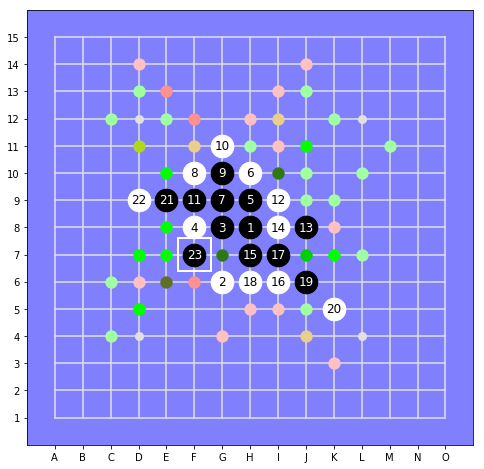

In [6]:
board.display(WHITE)

#### Creating a single sample

This function creates a *fenced* view on the board - a representation that can easily be digested by neural networks. From black viewpoint the board looks like it is surrounded by white stones. For white, it's the other way round. This allows a convolutional network to take the edges into account.

In [7]:
def create_sample(stones, N, viewpoint):
    
    sample = np.zeros([2, N, N], dtype=np.uint8)

    current = BLACK
    for move in stones:
        r,c=gt.b2m(move,N)
        sample[current][r][c]=1
        current = 1 - current
    
    offensive = np.hstack([
        np.zeros([N+2,1], dtype=np.uint8), 
        np.vstack([np.zeros(N, dtype=np.uint8), 
                   sample[viewpoint], 
                   np.zeros(N, dtype=np.uint8)]),
        np.zeros([N+2,1], dtype=np.uint8)
    ])
    
    defensive = np.hstack([
        np.ones([N+2,1], dtype=np.uint8), 
        np.vstack([np.ones(N, dtype=np.uint8), 
                   sample[1-viewpoint], 
                   np.ones(N, dtype=np.uint8)]),
        np.ones([N+2,1], dtype=np.uint8)
    ])
    both = np.array([offensive, defensive])
    return np.rollaxis(both, 0, 3)

We roll the channel axis to the front to have an easy-to-grasp idea of what the above function is doing

In [8]:
# view point is the next player, not the current
nextplayer = 1 - board.current_color
sample = create_sample(board.stones, 15, 1 - board.current_color)
np.rollaxis(sample, 2,0)

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 

---
### Heuristic labels for policies and Q-functions

The ```heuristic_counts``` function counts the offensive potential and the defensive potential per position from the given view point. This is a good basis for labelling boards when training deep Q-functions or policies.

In [9]:
def heuristic_counts(board, player):

    counts = board.counts.copy()

    for _player in [0, 1]:
        board.compute_counts(_player)

        for stone in board.stones:
            r,c = gt.b2m(stone, board.N)
            counts[_player][r][c] = 0

    return [counts[player], counts[1-player]]

In [10]:
heuristic_counts(board, nextplayer)

[array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 3.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 3.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 5.        ,
         0.        , 0.        , 0.        , 3.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 1.        , 0.        ,
         5.        , 1.        , 3.        , 3.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 1.78179744, 1.        ,
         1.78179744, 0.        , 1.        , 3.6553942 , 1.        ,
         0.        , 0.       

## Labelling for the Q-function's pre-training
The first step is to learn from a heuristic Q-Function. So we'll construct a reasonable Q-function from the offensive and defensive scores.

The rationell is: If a move is somewhat positiv in terms of the given heuristics then we estimate that it brings us closer to winning the game, which is why we assign it a higher Q-Value estimate. However, this is only the initial estimate. RL will need to do its job, too.

Perhaps, the most obvious candidate heuristic Q-Function would compute: 
- If I can win: Q value maximum
- If I can avoid losing, half of that
- If I have a strong attack, half of the above
- If I can avoid a strong attack from the opponent, half of the above
- anything else: Take the sum of offensive and defensive counts